## Sensibilidade ITENS

### Goal: Estimate elasticity per item (MED and N-MED)

In [1]:
pip install pyathena holidays cachetools

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyathena import connect
import boto3 ### AWS acces to s3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from matplotlib.ticker import PercentFormatter

from sklearn import linear_model
from sklearn.metrics import r2_score
import statsmodels.api as sm

### 
import os
import holidays

from utils_panvel import sql_query

### Avoid refreshing cache results
from hashlib import sha256

# Supressing warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
### Overall options
pd.options.display.float_format = "{:,.2f}".format

## Load dataset 

In [4]:
%%time
df = sql_query(open("sensibilidade_all.sql", "r").read())

Result loaded from cache.
CPU times: user 5.04 s, sys: 921 ms, total: 5.96 s
Wall time: 4.98 s


In [5]:
### Extract daf stats

def simple_stats (df):
    print('\nTotal datapoints:', df.shape[0])
    print('\nTotal de items:', df.codigo_item.nunique())
    print('\nTotal de categorias:', df.categoria.nunique())
    
simple_stats(df)


Total datapoints: 2222342

Total de items: 11872

Total de categorias: 289


## Part A. Data formating / cleaning / filtering

In [6]:
## declare variáveis
df['data_emissao'] = pd.to_datetime(df['data_emissao'])
df[['quant','price', 'rent','ratio_discount']] = df[['quant', 'price', 'rent', 'ratio_discount']].apply(pd.to_numeric)

### Filter 0 -  Flag special dates (holidays, blackfriday)

In [7]:
### black friday
start_date_23 = '2023-11-15'
end_date_23 =  '2023-11-30'
mask_23 = (df['data_emissao'] >= start_date_23) & (df['data_emissao'] <= end_date_23)

### Gov 
gov_date_23 = '2023-03-31'
gov_23 = (df['data_emissao'] == gov_date_23) 

## Brazilain Holidays
feriados = holidays.country_holidays("BR")
feriados_23 = feriados["2023-01-01":"2024-01-30"]

# Add a new column for holidays
df.loc[df['data_emissao'].isin(feriados_23), 'special_dates'] = 1
df.loc[gov_23, 'special_dates'] = 1
df.loc[mask_23, 'special_dates'] = 1

## Replace boolean with an integer
df.special_dates = df.special_dates.replace({True: 1, np.nan: 0}).astype(int)

## Filter out nspecial dates
df = df[df['special_dates'] == 0]
df

,data_emissao,codigo_item,categoria,tipo_produto_gerencial,quant,price,rent,total_items_with_discount,ratio_discount,special_dates
0,2023-03-01,940690,TINTURA,NI,15.00,23.93,11.53,15.0000,100.00,0
1,2023-03-01,111297,HIDRATANTES.,NI,3.00,66.72,21.96,1.0000,33.33,0
2,2023-03-01,119114,CREME PREVENTIVO P/ASSADURAS,NI,12.00,46.39,20.11,7.0000,58.33,0
3,2023-03-01,104915,ANTI-IDADE,NI,5.00,119.99,47.42,0.0000,0.00,0
4,2023-03-01,120190,C1 - BARBITURICO,MARCA,1.00,90.67,27.75,1.0000,100.00,0
...,...,...,...,...,...,...,...,...,...,...
2222337,2024-03-01,112719,REMOVEDOR,NI,460.00,6.90,3.08,40.0000,8.70,0
2222338,2024-03-01,845990,AZIA E MA DIGESTAO,MARCA,262.00,3.11,1.03,6.0000,2.29,0
2222339,2024-03-01,659630,HIDRATANTES.,NI,22.00,15.88,5.50,1.0000,4.55,0
2222340,2024-03-01,97142,FACE,NI,51.00,33.68,13.95,10.0000,19.61,0


## Feature Engeniering
###  Percentage Rentability per item

In [8]:
df['rent_item_pct'] = (df['rent'] / ( df['price'] - df['rent']))* 100

# Filter out rows with infinity values in 'rent_pct' column
df = df[~df['rent_item_pct'].isin([np.inf, -np.inf])]

###  Extract sales frequency per item

In [134]:
## Criar range da data para calcular frequencia de compra

days = df['data_emissao'].nunique()

stats = df.groupby(['codigo_item', 'categoria', 'tipo_produto_gerencial'], dropna=False, as_index=True, sort=True).agg(
    {
        "data_emissao": ["nunique"],
         "ratio_discount": ["mean"],
         "rent_item_pct": ["mean"],
    }
)

stats.columns = stats.columns.droplevel(1)
stats.reset_index(inplace=True)
stats.rename(columns={'data_emissao': '#_dias', 'ratio_discount':'razao_quant_dexconto', "rent_item_pct": "rent_pct"}, inplace = True)
stats['dias_freq'] = (stats['#_dias'] / days )*100

## Frequency bands - use only to get some stats

frequency_bins = [x for x in range(0, 110, 10)]

def add_frequency_bands(df, field):
    df["frequency_band"] = pd.cut(df[field], frequency_bins)
    return df

stats = add_frequency_bands(stats, "dias_freq")

print('\n Dias avaliados:', days,
    '\n Proporção frequência média de vendas {:.2f}%'.format(round(stats.dias_freq.mean(), 2)),
    '\n Média da razão quantidade vendida com desconto {:.2f}%\n'.format(round(stats.razao_quant_dexconto.mean(), 2)))


 Dias avaliados: 242 
 Proporção frequência média de vendas 71.08% 
 Média da razão quantidade vendida com desconto 39.19%



In [135]:
stats.tipo_produto_gerencial.value_counts(dropna=False)

tipo_produto_gerencial
NI          8453
MARCA       2844
GENERICO     573
Name: count, dtype: int64

### Merge sales frequency with daily information

In [136]:
### merge dfs

df_elast = pd.merge(df, stats, left_on='codigo_item', right_on='codigo_item')
df_elast.drop(columns = ['categoria_x'], inplace = True)
df_elast.rename(columns = {'categoria_y':'categoria'}, inplace = True)
df_elast

,data_emissao,codigo_item,tipo_produto_gerencial_x,quant,price,rent,total_items_with_discount,ratio_discount,special_dates,rent_item_pct,categoria,tipo_produto_gerencial_y,#_dias,razao_quant_dexconto,rent_pct,dias_freq,frequency_band
0,2023-03-01,940690,NI,15.00,23.93,11.53,15.0000,100.00,0,92.93,TINTURA,NI,242,33.57,42.18,100.00,"(90, 100]"
1,2023-03-02,940690,NI,16.00,26.91,10.16,11.0000,68.75,0,60.63,TINTURA,NI,242,33.57,42.18,100.00,"(90, 100]"
2,2023-03-03,940690,NI,10.00,34.19,11.01,0.0000,0.00,0,47.50,TINTURA,NI,242,33.57,42.18,100.00,"(90, 100]"
3,2023-03-06,940690,NI,21.00,25.43,9.47,20.0000,95.24,0,59.34,TINTURA,NI,242,33.57,42.18,100.00,"(90, 100]"
4,2023-03-07,940690,NI,24.00,24.98,9.09,24.0000,100.00,0,57.23,TINTURA,NI,242,33.57,42.18,100.00,"(90, 100]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041839,2024-03-01,95088,MARCA,1.00,54.22,20.31,1.0000,100.00,0,59.89,C1 - BARBITURICO,MARCA,1,100.00,59.89,0.41,"(0, 10]"
2041840,2024-03-01,95063,MARCA,1.00,42.67,11.71,0.0000,0.00,0,37.82,DESCONGESTIONANTES NASAIS,MARCA,1,0.00,37.82,0.41,"(0, 10]"
2041841,2024-03-01,95454,NI,1.00,15.19,2.66,1.0000,100.00,0,21.23,HIDRATANTES.,NI,1,100.00,21.23,0.41,"(0, 10]"
2041842,2024-03-01,95357,GENERICO,1.00,27.99,15.89,1.0000,100.00,0,131.32,A2 - BARBITURICO,GENERICO,1,100.00,131.32,0.41,"(0, 10]"


## Part B. Estimate Elasticity (per item)

### Log-Log linear regression - estimated beta (slope) is the estimated elasticity

In [ ]:
%%time

### Log transformed variables

df_elast['log_q'] = np.log(df_elast['quant'])
df_elast['log_price'] = np.log(df_elast['price'])

### Iterate per item

df_index = []
coef_mtr = []
r2_mtr = []

items = list(set(df_elast['codigo_item']))
for i in items:
    #print('\n Codigo item', i)
    df_redux = df_elast[df_elast['codigo_item']==i]
    #  print(df_redux)
    X = df_redux[['log_price']]
    Y = df_redux['log_q']

    # Store parameters
#     elast_coef =  regr.coef_

#     coef_mtr.append(elast_coef)
#     df_index.append(i)

    # with statsmodels
    X = sm.add_constant(X) # adding a constant
    model = sm.OLS(Y, X).fit()
    # predictions = model.predict(X)
    r2 = model.rsquared
    elast_coef =  model.params
   # print(model.summary())
    
    # Store reulsts
    coef_mtr.append(elast_coef)
    r2_mtr.append(r2)
    df_index.append(i)
    
r2_mtr= pd.DataFrame(r2_mtr, index =list(set(df_elast['codigo_item'])) )
coef_mtr = pd.DataFrame(coef_mtr, index =list(set(df_elast['codigo_item'])) )

# r2_mtr.index = list(set(df_ols['codigo_item']))

results = pd.merge(coef_mtr, r2_mtr, left_index=True, right_index=True)
results.rename(columns = {'log_price':'elasticity_price',0 :'r2_score'}, inplace = True)
# results.reset_index(inplace=True)

results.to_parquet('elasticity_itens.parquet')

results                   

CPU times: user 1h 42min 11s, sys: 432 ms, total: 1h 42min 12s
Wall time: 1h 42min 12s


,const,elasticity_price,r2_score
104209,0.00,0.00,NaN
98319,6.34,-1.09,0.02
27,-3.26,1.91,0.01
131105,-3.63,1.55,0.06
884770,6.70,-0.82,0.13
...,...,...,...
98292,-3.16,1.40,0.00
98293,-8.23,2.74,0.01
98294,5.46,-1.01,0.17
98295,7.87,-1.88,0.02


In [17]:
# r2_mtr= pd.DataFrame(r2_mtr, index =list(set(df_elast['codigo_item'])) )
# coef_mtr = pd.DataFrame(coef_mtr, index =list(set(df_elast['codigo_item'])) )

# # r2_mtr.index = list(set(df_ols['codigo_item']))

# results = pd.merge(coef_mtr, r2_mtr, left_index=True, right_index=True)
# results.rename(columns = {'log_price':'elasticity_price',0 :'r2_score'}, inplace = True)
# # results.reset_index(inplace=True)

# results.to_parquet('elasticity_itens.parquet')

# results

In [137]:
### Get elasticity itens -> don't need to run the regressiosn again (takes toooo long)

# Read the Parquet file into a DataFrame using pandas
results_item = pd.read_parquet('elasticity_itens.parquet')

print('\nTotal de itens para os quais foi calculado a elasticidade:', len(results_item))


Total de itens para os quais foi calculado a elasticidade: 11996


### Melhoranbdo a inbterpretação

* Para o cálculo da elasticidade, pode-se considerar apenas o módulo;

* O sinal negativo serve apenas para representar está correlação negativa.
    * Pois para todo aumento de preço em bens normais, há uma redução da quantidade demandada.

### Debug results

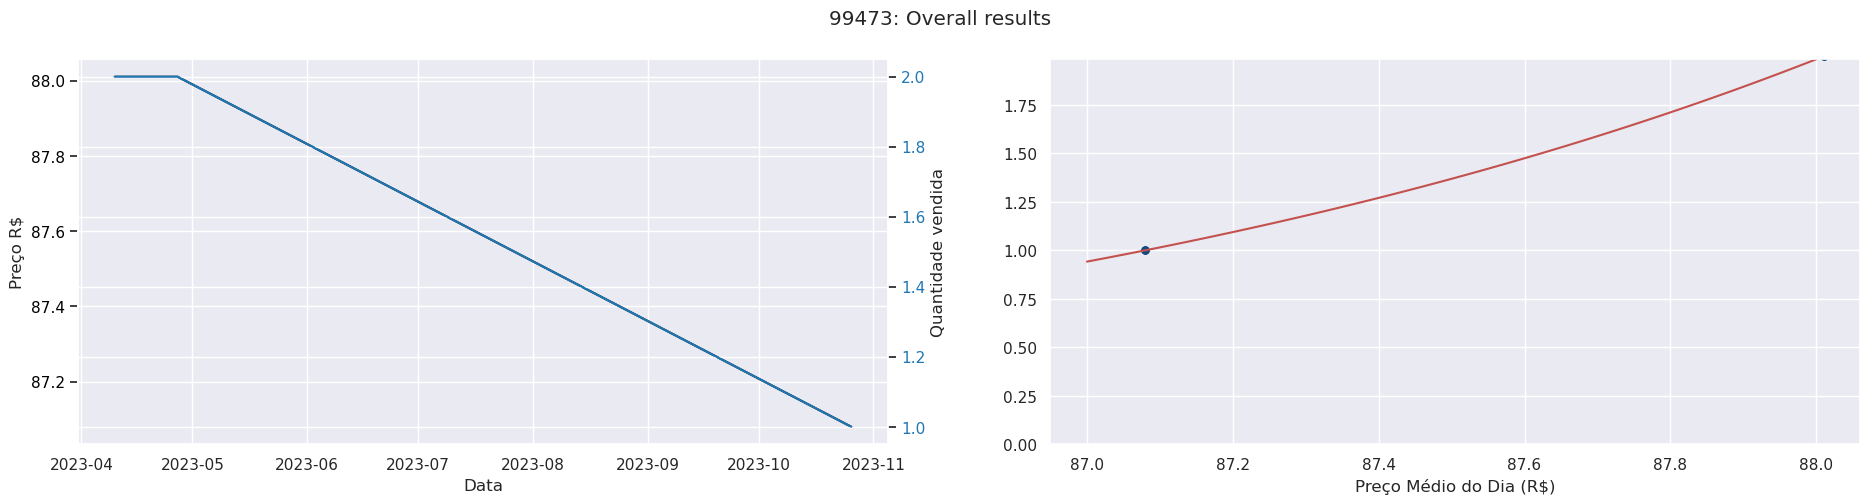

In [139]:
### View some data

result_item = results_item.reset_index()
result_item .rename(columns={'index': 'codigo_item'}, inplace = True)

item = 99473
result_item= result_item[result_item['codigo_item']== item]

intercept = result_item['const'].values
slope = result_item['elasticity_price'].values

df_item = df_elast[df_elast['codigo_item']== item]

preco_min = int(df_item['price'].min())
preco_max = int(df_item['price'].max())

# Calculate the y-values for the endpoints of the curve using the slope and intercept
x_line = np.linspace(preco_min, preco_max, 100)
y_line = np.exp(intercept) * (x_line ** (slope))


### Plot log function and scatter plot 

# Create subplots with two charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23, 5))

## First plot
### 1 y-axis
color = 'black'
ax1.set_xlabel('Data')
ax1.set_ylabel('Preço R$')
ax1.plot(df_item['data_emissao'], df_item['price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

### 2 y-axis
ax1twin = ax1.twinx()
color = 'tab:blue'
ax1twin .set_ylabel('Quantidade vendida')
ax1twin .plot(df_item['data_emissao'], df_item['quant'], color=color)
ax1twin .tick_params(axis='y', labelcolor=color)

## Second plot
sns.scatterplot(x='price', y='quant', data=df_item, s=50, color = '#174A7E', ax=ax2)
ax2.set_ylim(0, y_line.max())
ax2.plot(x_line, y_line, color='#C3514E', label='Curva de Demanda')

ax2.set_ylabel('')
ax2.set_xlabel('Preço Médio do Dia (R$)')


plt.suptitle(f'{item}: Overall results')
plt.show()

## Part C - Drop strange elasticity values

In [140]:
## If a have run the elasticity algorithn
# results_1 = results.copy()

##  Otherwise 
results_1 = results_item.copy()

results_1 = results_1.reset_index()
results_1.rename(columns = {'index': 'codigo_item'}, inplace = True)
results_1 = pd.merge(results_1, stats, left_on='codigo_item', right_on='codigo_item')

## Store the original item elasticity 
results_1['elast_ORIGINAL'] = results_1['elasticity_price']
results_1['r2_ORIGINAL'] = results_1['r2_score']

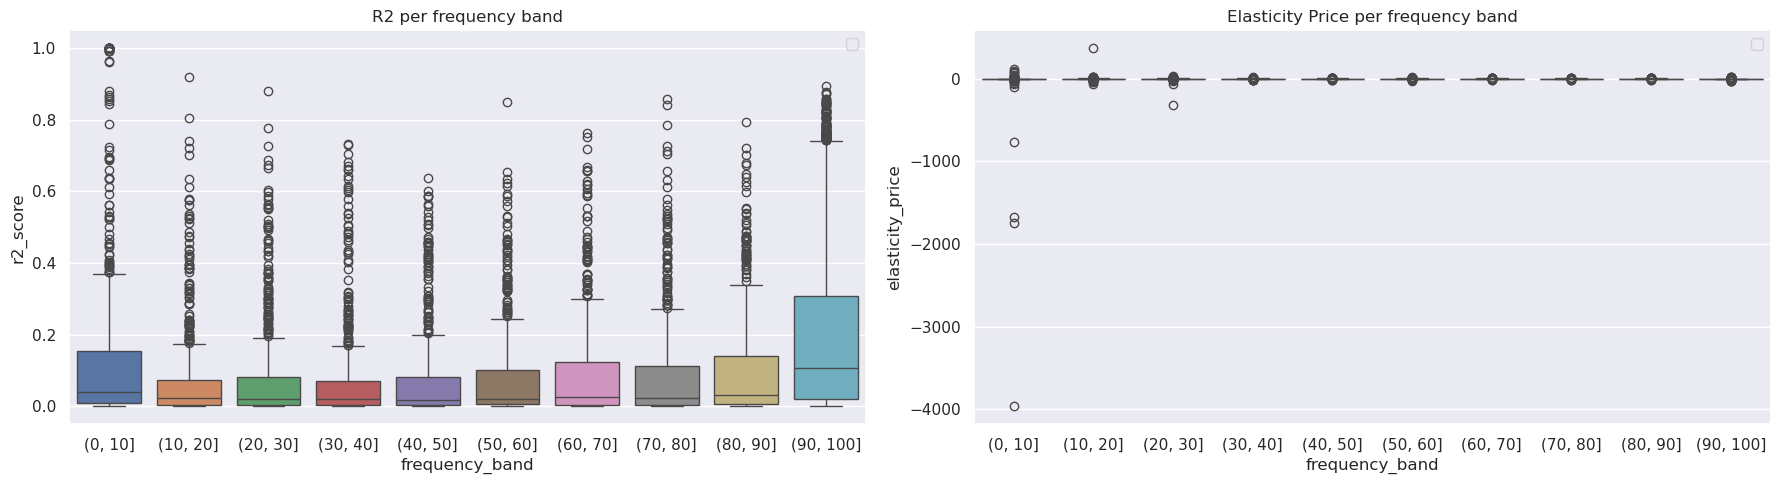

In [142]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# First subplot - R2 Score
sns.boxplot(x="frequency_band",
            y="r2_score",
            data=results_1,
            hue="frequency_band",
            ax=axes[0])

axes[0].set_title('R2 per frequency band')
axes[0].legend('')

# Second subplot - Elasticity Price
sns.boxplot(x="frequency_band",
            y="elasticity_price",
            data=results_1,
            hue="frequency_band",
            ax=axes[1])

axes[1].set_title('Elasticity Price per frequency band')
axes[1].legend('')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Replace iten elasticity

### Situations: 
* Heuristic 1: itens with a daily sales frequency less than 30% 

* Heuristic 2:  Itens with $r^2 $ = -inf $\rightarrow$ normally associaterd with low frequency of datapoints)

* Heuristic 3:  Itens with very high $r^2 >0.90 $ $\rightarrow$ normally associaterd with low frequency of datapoints)

* Heuristic 4:  Itens with $elasticity = -inf $ $\rightarrow$ must replace $r^2 $ with the category  $r^2 $ value

* Heuristic 5:  Itens with elasticity is null   $\rightarrow$ must replace $r^2 $ with the category  $r^2 $ value

* Heuristic 6:  Itens with very low $elasticity < - 20  $  &   low  $r^2 $ $\rightarrow$ something  is up with sales performance 

* Heuristic 7:  Itens with $r^2 < 0.10 $ $\rightarrow$ sparse data -> replace by category values 

In [143]:
# Heuristics 1
results_1.loc[results_1['dias_freq'] < 30, 'elasticity_price'] = np.nan

# Heuristics 2
results_1.loc[results_1['r2_score'] == -np.inf, 'elasticity_price'] = np.nan

# Heuristics 3
results_1.loc[results_1['r2_score'] >= 0.90, 'elasticity_price'] = np.nan

# Heuristics 4:
results_1.loc[results_1['elasticity_price'] == -np.inf, 'r2_score'] = np.nan

# Heuristics 5:
results_1.loc[results_1['elasticity_price'].isnull(), 'r2_score'] = np.nan

# Heuristics 6:
results_1.loc[results_1['elasticity_price'] <= -20, 'r2_score'] = np.nan
results_1.loc[results_1['elasticity_price'] <= -20, 'elasticity_price'] = np.nan

# Heuristics 7:
results_1.loc[results_1['r2_score'] <= 0.05, 'elasticity_price'] = np.nan
results_1.loc[results_1['r2_score'] <= 0.05, 'r2_score'] = np.nan

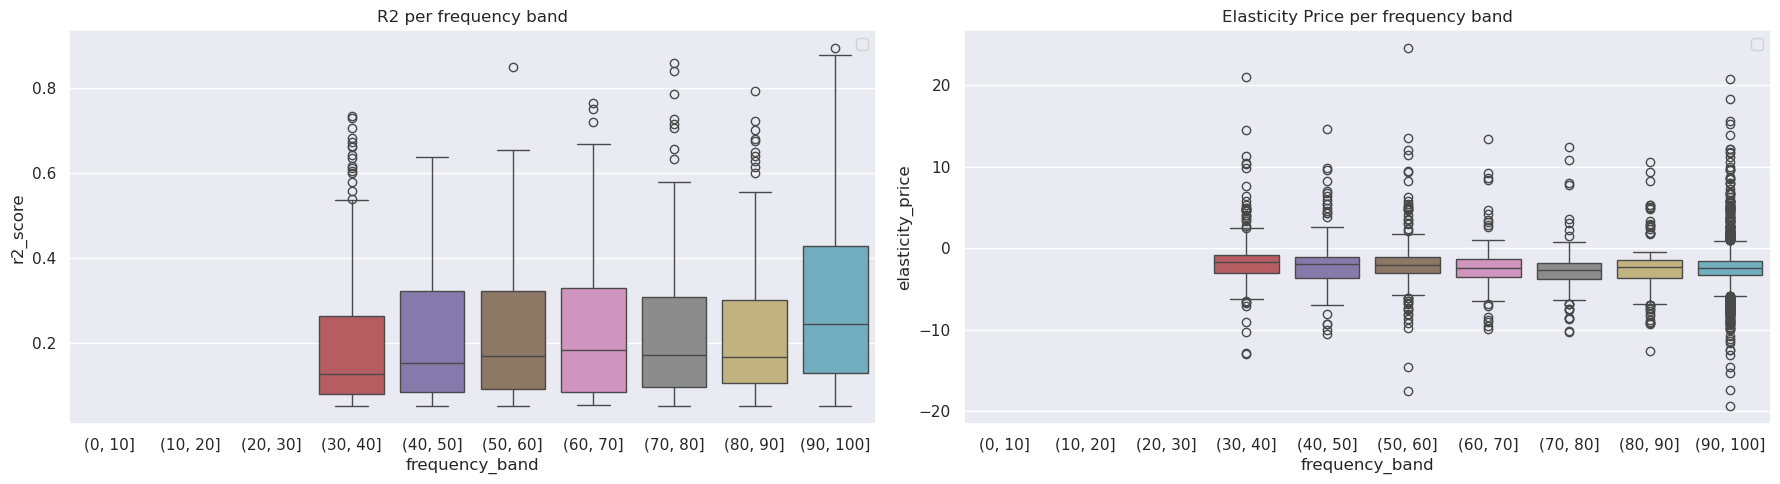

In [145]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# First subplot - R2 Score
sns.boxplot(x="frequency_band",
            y="r2_score",
            data=results_1,
            hue="frequency_band",
            ax=axes[0])

axes[0].set_title('R2 per frequency band')
axes[0].legend('')

# Second subplot - Elasticity Price
sns.boxplot(x="frequency_band",
            y="elasticity_price",
            data=results_1,
            hue="frequency_band",
            ax=axes[1])

axes[1].set_title('Elasticity Price per frequency band')
axes[1].legend('')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Get category values

In [147]:
# Read the Parquet file into a DataFrame using pandas
df_category = pd.read_parquet('elasticity_category.parquet')
df_category.reset_index(inplace = True)
df_category.rename(columns={'elasticity_price':'elasticity_category', 'r2_score':'r2_category'}, inplace= True)
df_category

,categoria,elasticity_category,r2_category
0,A1 - BARBITURICO,-0.49,0.02
1,A2 - BARBITURICO,-1.19,0.15
2,A3 - BARBITURICO,-0.33,0.02
3,ABSORVENTE EXTERNO,-1.64,0.28
4,ABSORVENTE INTERNO,-2.29,0.30
...,...,...,...
264,UNHAS E ACESSORIOS,-0.56,0.06
265,UTILIDADES,-0.55,0.18
266,VERRUGAS,-1.79,0.05
267,VITAMINAS AZ,-1.49,0.21


Atenção: devido a filtros que foram utilizados para se chegar as principais categorias, alguns itens podem não ter uma contrapartida em categoria. 

In [149]:
results_1.sort_values(by = 'codigo_item', inplace = True)
results_1

,codigo_item,const,elasticity_price,r2_score,categoria,tipo_produto_gerencial,#_dias,razao_quant_dexconto,rent_pct,dias_freq,frequency_band,elast_ORIGINAL,r2_ORIGINAL
2,27,-3.26,NaN,NaN,VITAMINAS AZ,MARCA,155,10.35,41.87,64.05,"(60, 70]",1.91,0.01
101,390,-0.47,NaN,NaN,PUERICULTURA,NI,50,46.00,54.64,20.66,"(20, 30]",0.19,0.01
199,655,6.36,NaN,NaN,C5 - BARBITURICO,MARCA,241,99.62,43.72,99.59,"(90, 100]",-0.28,0.02
585,1220,7.54,-1.29,0.05,LENCO INTIMO,NI,242,23.66,65.71,100.00,"(90, 100]",-1.29,0.05
1135,2170,1.58,NaN,NaN,C1 - BARBITURICO,GENERICO,78,97.22,18.65,32.23,"(30, 40]",-0.29,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6939,998830,4.04,NaN,NaN,ESMALTAÇÃO,NI,242,14.12,67.19,100.00,"(90, 100]",-0.11,0.00
6957,998870,5.28,NaN,NaN,ESMALTAÇÃO,NI,242,12.76,67.32,100.00,"(90, 100]",-1.35,0.01
6968,998890,7.56,NaN,NaN,ESMALTAÇÃO,NI,242,13.07,66.89,100.00,"(90, 100]",-2.37,0.02
6972,998900,7.59,NaN,NaN,ESMALTAÇÃO,NI,242,13.62,67.11,100.00,"(90, 100]",-2.26,0.02


In [150]:
results_2 = pd.merge(results_1, df_category, on='categoria', how='left')
# Create a new column 'nan_replaced_flag' to indicate if NaN values were replaced
results_2['utilizado_elasticidade_categoria'] = np.where(results_2['elasticity_price'].isna(), 1, 0)
results_2.utilizado_elasticidade_categoria.value_counts()

utilizado_elasticidade_categoria
1    6720
0    5055
Name: count, dtype: int64

### Replace values

In [153]:
# Replace NaN values i
results_2['elasticity_price'] = results_2['elasticity_price'].fillna(results_2['elasticity_category'])
results_2['r2_score'] = results_2['r2_score'].fillna(results_2['r2_category'])

### Alguns itens ainda apresentaram problemas no calculo da elasticidade
results_2.dropna(subset=["elasticity_price"], inplace=True)

results_2['elasticity_price'].isnull().sum()

0

## Aplicando regras para elasticidade e grau de confiança

## Regra definida com pricing 

In [156]:
### Export data to pricing

# Assuming you have a DataFrame named df
df_elast_2 = results_2[['codigo_item','categoria', 'tipo_produto_gerencial','elast_ORIGINAL', 'r2_ORIGINAL',  'elasticity_category', 'r2_category','utilizado_elasticidade_categoria','elasticity_price', 'r2_score', 'razao_quant_dexconto', 'rent_pct']]

####### APPLY CONDITIONS ############################
### ITENS
df_elast_2['elasticidade_abs'] = np.abs(df_elast_2['elasticity_price'])
# Define elasticity conditions 
conditions_elasticity = [
    (df_elast_2['elasticidade_abs'] <= 1.4),
    ((1.4 < df_elast_2['elasticidade_abs']) & (df_elast_2['elasticidade_abs'] < 2.8)),
    (df_elast_2['elasticidade_abs'] >= 2.8)
]

values = ['low', 'average', 'high']

# Create a new column based on conditions
df_elast_2['elasticidade_item_regra'] = np.select(conditions_elasticity, values)
df_elast_2 = df_elast_2[df_elast_2['elasticidade_item_regra'] != '0']

# # # # Extract seleected features
# df_elast_2 = df_elast_2[['codigo_item','categoria', 'elast_ORIGINAL', 'r2_ORIGINAL', 'elasticity_category', 'r2_category', 'utilizado_elasticidade_categoria','elasticity_price','elasticidade_item_regra', 
#                         'razao_quant_dexconto', 'rent_pct']]

df_elast_2

,codigo_item,categoria,tipo_produto_gerencial,elast_ORIGINAL,r2_ORIGINAL,elasticity_category,r2_category,utilizado_elasticidade_categoria,elasticity_price,r2_score,razao_quant_dexconto,rent_pct,elasticidade_abs,elasticidade_item_regra
0,27,VITAMINAS AZ,MARCA,1.91,0.01,-1.49,0.21,1,-1.49,0.21,10.35,41.87,1.49,average
1,390,PUERICULTURA,NI,0.19,0.01,-0.64,0.01,1,-0.64,0.01,46.00,54.64,0.64,low
2,655,C5 - BARBITURICO,MARCA,-0.28,0.02,-0.32,0.16,1,-0.32,0.16,99.62,43.72,0.32,low
3,1220,LENCO INTIMO,NI,-1.29,0.05,-1.54,0.22,0,-1.29,0.05,23.66,65.71,1.29,low
4,2170,C1 - BARBITURICO,GENERICO,-0.29,0.01,-1.68,0.32,1,-1.68,0.32,97.22,18.65,1.68,average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11770,998830,ESMALTAÇÃO,NI,-0.11,0.00,-0.95,0.10,1,-0.95,0.10,14.12,67.19,0.95,low
11771,998870,ESMALTAÇÃO,NI,-1.35,0.01,-0.95,0.10,1,-0.95,0.10,12.76,67.32,0.95,low
11772,998890,ESMALTAÇÃO,NI,-2.37,0.02,-0.95,0.10,1,-0.95,0.10,13.07,66.89,0.95,low
11773,998900,ESMALTAÇÃO,NI,-2.26,0.02,-0.95,0.10,1,-0.95,0.10,13.62,67.11,0.95,low


In [159]:
df_plot = df_elast_2[(df_elast_2['rent_pct'] >= -50) & (df_elast_2['rent_pct'] <= 100)]

df_plot = df_plot.dropna(subset=['elasticity_price', 'rent_pct'])

df_plot

,codigo_item,categoria,tipo_produto_gerencial,elast_ORIGINAL,r2_ORIGINAL,elasticity_category,r2_category,utilizado_elasticidade_categoria,elasticity_price,r2_score,razao_quant_dexconto,rent_pct,elasticidade_abs,elasticidade_item_regra
0,27,VITAMINAS AZ,MARCA,1.91,0.01,-1.49,0.21,1,-1.49,0.21,10.35,41.87,1.49,average
1,390,PUERICULTURA,NI,0.19,0.01,-0.64,0.01,1,-0.64,0.01,46.00,54.64,0.64,low
2,655,C5 - BARBITURICO,MARCA,-0.28,0.02,-0.32,0.16,1,-0.32,0.16,99.62,43.72,0.32,low
3,1220,LENCO INTIMO,NI,-1.29,0.05,-1.54,0.22,0,-1.29,0.05,23.66,65.71,1.29,low
4,2170,C1 - BARBITURICO,GENERICO,-0.29,0.01,-1.68,0.32,1,-1.68,0.32,97.22,18.65,1.68,average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11770,998830,ESMALTAÇÃO,NI,-0.11,0.00,-0.95,0.10,1,-0.95,0.10,14.12,67.19,0.95,low
11771,998870,ESMALTAÇÃO,NI,-1.35,0.01,-0.95,0.10,1,-0.95,0.10,12.76,67.32,0.95,low
11772,998890,ESMALTAÇÃO,NI,-2.37,0.02,-0.95,0.10,1,-0.95,0.10,13.07,66.89,0.95,low
11773,998900,ESMALTAÇÃO,NI,-2.26,0.02,-0.95,0.10,1,-0.95,0.10,13.62,67.11,0.95,low


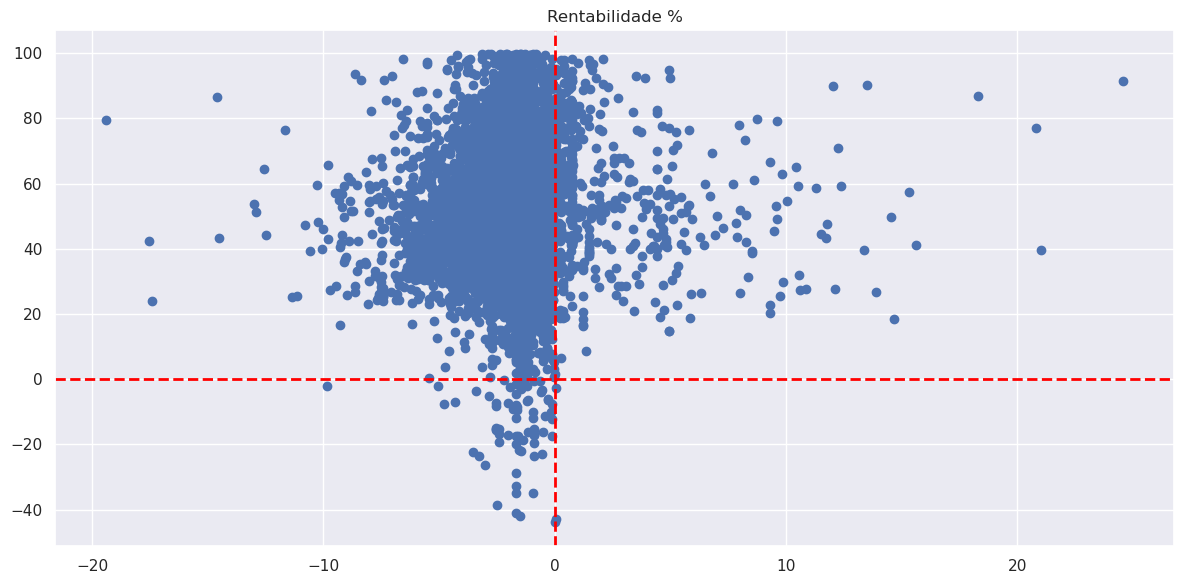

In [160]:
# Scatter plot 1

plt.figure(figsize=(12, 6))  # Adjust the values (width, height) as needed


plt.scatter(df_plot['elasticity_price'], df_plot['rent_pct'])
# Add a horizontal line at y = 0
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Rentabilidade %')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

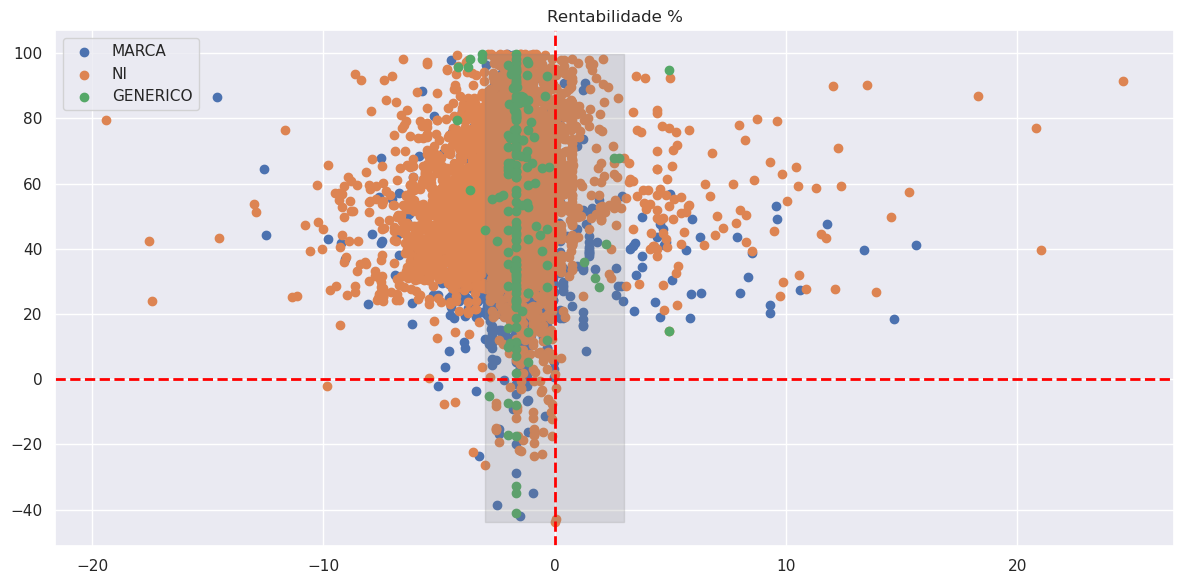

In [164]:
# Scatter plot 1

plt.figure(figsize=(12, 6))  # Adjust the values (width, height) as needed


categories = df_plot['tipo_produto_gerencial'].unique()
for category in categories:
    subset = df_plot[df_plot['tipo_produto_gerencial'] == category]
    plt.scatter(subset['elasticity_price'], subset['rent_pct'], label=category)
plt.title('Proporção de vendas com desconto')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.fill_between(x=[-3, 3], y1=min(df_plot['rent_pct']), y2=max(df_plot['rent_pct']), color='gray', alpha=0.2)  # Shaded area
plt.title('Rentabilidade %')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.legend()
# Show the plots
plt.show()

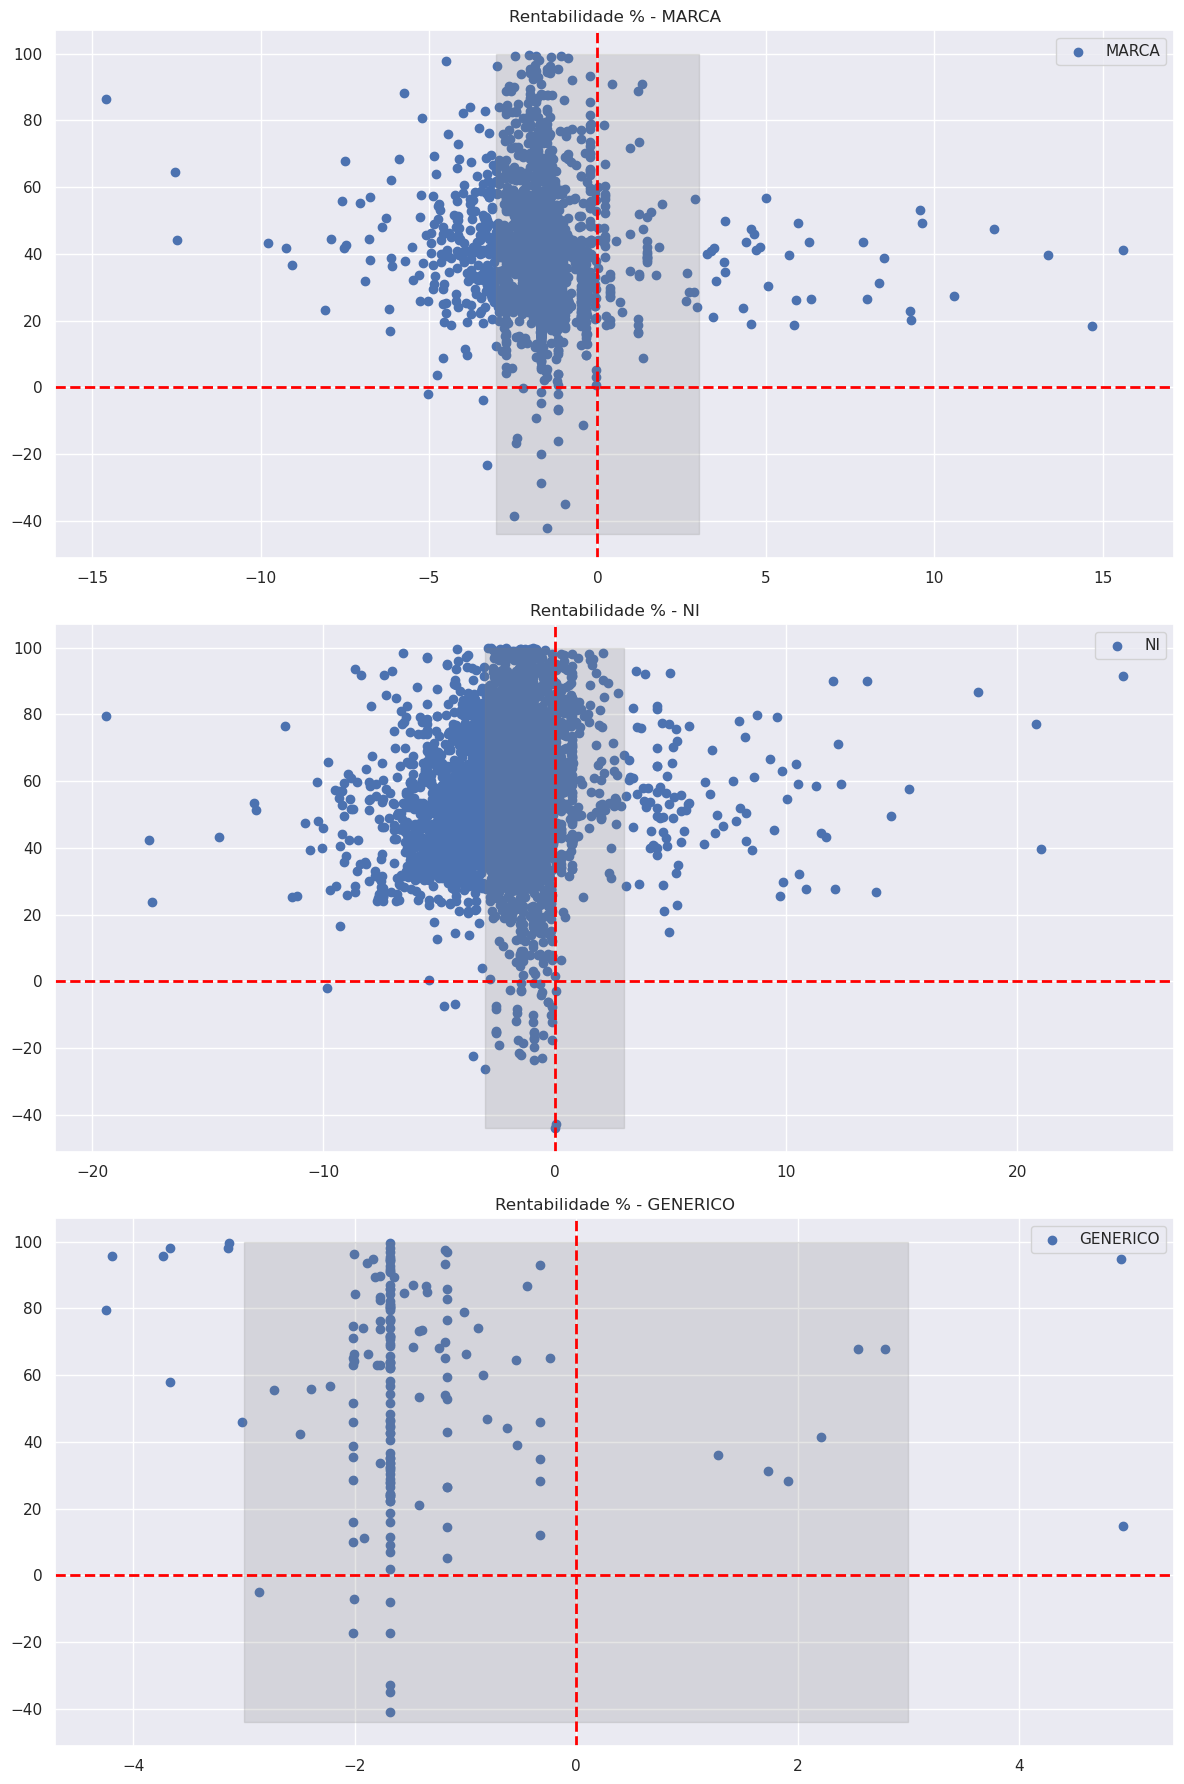

In [165]:
import matplotlib.pyplot as plt

# Determine the number of categories
categories = df_plot['tipo_produto_gerencial'].unique()
n_categories = len(categories)

# Create a figure to hold the subplots
# Adjust the figure size as needed
fig, axs = plt.subplots(n_categories, 1, figsize=(12, 6 * n_categories))

# Check if axs is not an array (happens when there's only one subplot), and make it an array
if n_categories == 1:
    axs = [axs]

# Loop over each category to create a separate subplot
for ax, category in zip(axs, categories):
    subset = df_plot[df_plot['tipo_produto_gerencial'] == category]
    ax.scatter(subset['elasticity_price'], subset['rent_pct'], label=category)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.fill_between(x=[-3, 3], y1=min(df_plot['rent_pct']), y2=max(df_plot['rent_pct']), color='gray', alpha=0.2)
    ax.set_title(f'Rentabilidade % - {category}')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


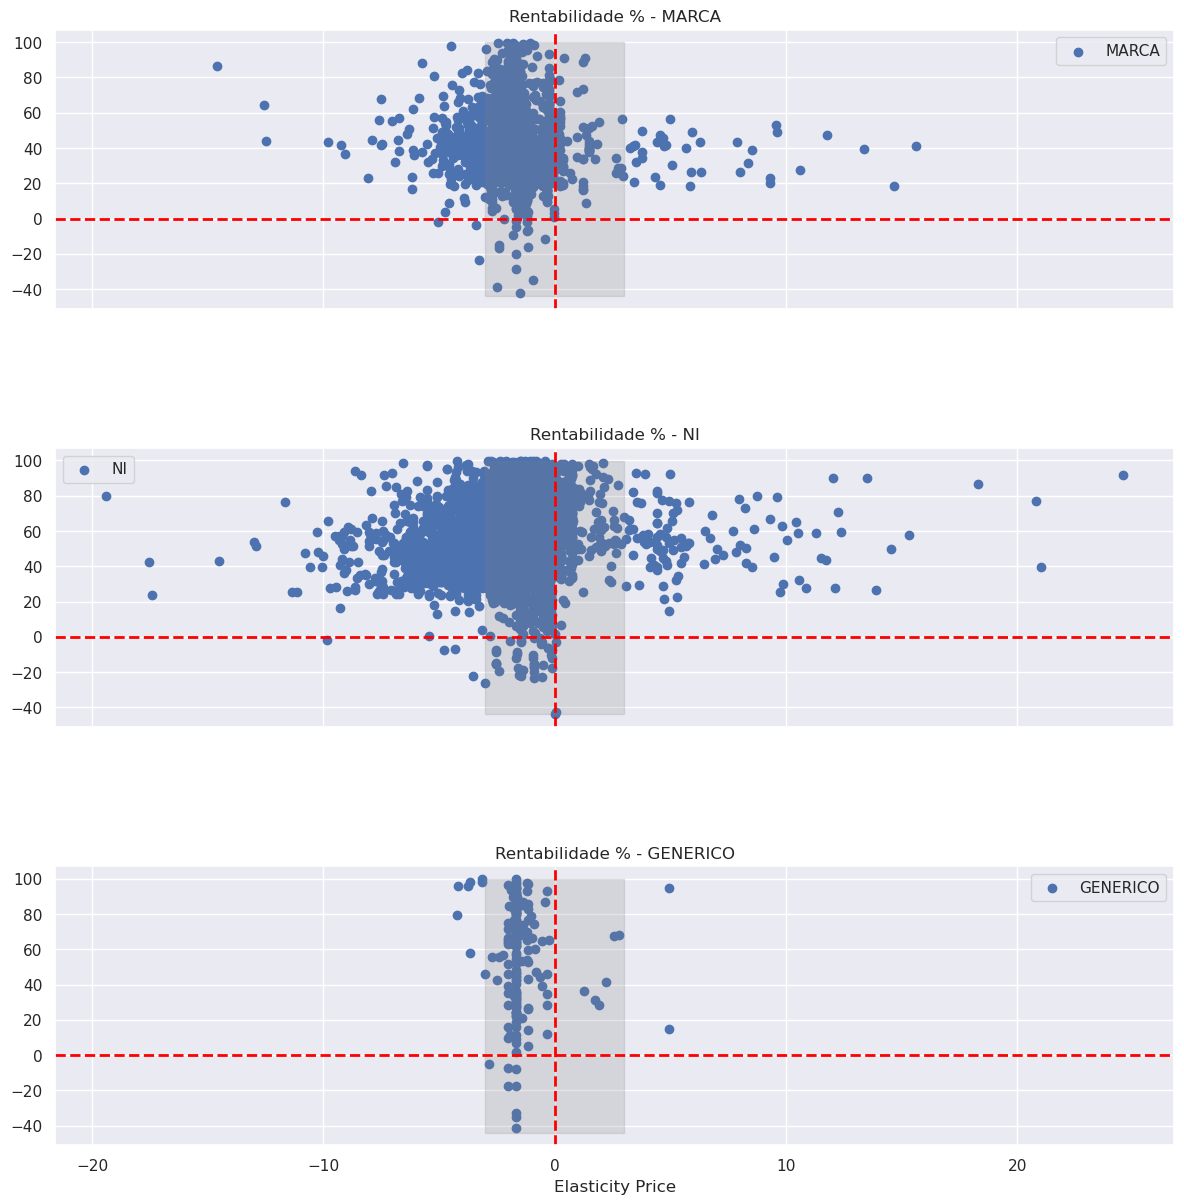

In [166]:
import matplotlib.pyplot as plt

# Determine the number of categories
categories = df_plot['tipo_produto_gerencial'].unique()
n_categories = len(categories)

# Create a figure to hold the subplots with shared x-axis
fig, axs = plt.subplots(n_categories, 1, figsize=(12, 4 * n_categories), sharex=True)  # Adjust figsize as needed

# Ensure axs is iterable in the case of a single subplot
if n_categories == 1:
    axs = [axs]

# Loop over each category to create a separate subplot
for ax, category in zip(axs, categories):
    subset = df_plot[df_plot['tipo_produto_gerencial'] == category]
    ax.scatter(subset['elasticity_price'], subset['rent_pct'], label=f'{category}')
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.fill_between(x=[-3, 3], y1=min(df_plot['rent_pct']), y2=max(df_plot['rent_pct']), color='gray', alpha=0.2)
    ax.set_title(f'Rentabilidade % - {category}')
    ax.legend()

# Adjust layout to prevent overlap and to ensure the x-axis labels don't get cut off
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Adjust the space between plots

# Only set x-label for the bottom subplot if necessary
axs[-1].set_xlabel('Elasticity Price')

# Show the plots
plt.show()


### Avaliando outras possibilidades

In [22]:
### Export data to pricing

# Assuming you have a DataFrame named df
df_elasticity = results_2[['codigo_item','categoria', 'elast_ORIGINAL', 'r2_ORIGINAL',  'elasticity_category', 'r2_category','utilizado_elasticidade_categoria','elasticity_price', 'r2_score', 'razao_quant_dexconto']]

####### APPLY CONDITIONS ############################
### ITENS
df_elasticity['elasticidade_abs'] = np.abs(df_elasticity['elasticity_price'])

# # Define elasticity conditions 
conditions_elasticity = [
    (df_elasticity['elasticidade_abs'] >= 1),
    (df_elasticity['elasticidade_abs'] < 1)
]

values = ['elastico', 'inelastico']

# Create a new column based on conditions
df_elasticity['elasticidade_item_regra'] = np.select(conditions_elasticity, values)
df_elasticity = df_elasticity[df_elasticity['elasticidade_item_regra'] != '0']

# Define r2 conditions 
conditions_r2 = [
    (df_elasticity['r2_score'] >= 0.35),
    (df_elasticity['r2_score'] <= 0.15),
    ((df_elasticity['r2_score'] > 0.15) & (df_elasticity['r2_score'] < 0.35))
]

values = ['alta', 'baixa', 'média']

# Create a new column based on conditions
df_elasticity['confianca_item_regra'] = np.select(conditions_r2, values)


### CATEGORY

df_elasticity['elasticidade_abs_cat'] = np.abs(df_elasticity['elasticity_category'])
# # Define elasticity conditions 
conditions_elasticity_cat = [
    (df_elasticity['elasticidade_abs_cat'] >= 2),
    (df_elasticity['elasticidade_abs_cat'] < 2)
]

values = ['elastico', 'inelastico']

# Create a new column based on conditions
df_elasticity['elasticidade_categoria_regra'] = np.select(conditions_elasticity_cat, values)


# Define r2 conditions 
conditions_r2_cat = [
    (df_elasticity['r2_category'] >= 0.35),
    (df_elasticity['r2_category'] <= 0.15),
    ((df_elasticity['r2_category'] > 0.15) & (df_elasticity['r2_category'] < 0.35))
]

values = ['alta', 'baixa', 'média']

# # Create a new column based on conditions
df_elasticity['confianca_categoria_regra'] = np.select(conditions_r2_cat, values)

# df_elasticity.rename(columns = {'elasticidade_abs':'elasticidade_item_valor', 'replaced_category_flag':'utilizado_elasticidade_categoria', 'elasticidade_abs_cat':'elasticidade_categoria_valor'}, inplace= True)

# # Extract seleected features
df_elasticity = df_elasticity[['codigo_item','categoria', 'elast_ORIGINAL', 'r2_ORIGINAL', 'elasticity_category', 'r2_category', 'utilizado_elasticidade_categoria','elasticidade_item_regra','confianca_item_regra', 
                               'elasticidade_categoria_regra','confianca_categoria_regra', 'razao_quant_dexconto']]


df_elasticity.rename(columns = {'elast_ORIGINAL':'elast_item', 'r2_ORIGINAL':'confianca_item'  , 'elasticity_category':'elast_categoria', 'r2_category':'confianca_categoria'}, inplace= True)


df_elasticity.head(10)

,codigo_item,categoria,elast_item,confianca_item,elast_categoria,confianca_categoria,utilizado_elasticidade_categoria,elasticidade_item_regra,confianca_item_regra,elasticidade_categoria_regra,confianca_categoria_regra,razao_quant_dexconto
0,27,VITAMINAS AZ,1.91,0.01,-1.49,0.21,1,elastico,média,inelastico,média,10.69
1,390,PUERICULTURA,0.19,0.01,-0.64,0.01,1,inelastico,baixa,inelastico,baixa,35.94
2,655,C5 - BARBITURICO,-0.28,0.02,-0.32,0.16,1,inelastico,média,inelastico,média,99.57
3,1220,LENCO INTIMO,-1.29,0.05,-1.54,0.22,0,elastico,baixa,inelastico,média,25.06
4,2170,C1 - BARBITURICO,-0.29,0.01,-1.68,0.32,1,elastico,média,inelastico,média,96.95
5,2340,C1 - BARBITURICO,-0.81,0.25,-1.68,0.32,1,elastico,média,inelastico,média,96.88
6,2790,DOR E CONTUSÃO,0.42,0.01,-1.23,0.15,1,elastico,baixa,inelastico,baixa,10.26
7,2800,CREME TRATAMENTO P/ CORPO,-2.40,0.05,-1.05,0.01,0,elastico,baixa,inelastico,baixa,28.28
8,3018,COLICAS,-0.24,0.00,-0.20,0.18,1,inelastico,média,inelastico,média,10.74
9,3158,VITAMINAS AZ,-1.06,0.16,-1.49,0.21,0,elastico,média,inelastico,média,58.20


In [157]:
df_plot = df_elast_2[(df_elast_2['rent_pct'] >= -50) & (df_elast_2['rent_pct'] <= 100)]

df_plot = df_plot.dropna(subset=['elasticity_price', 'rent_pct'])

df_plot

,codigo_item,categoria,tipo_produto_gerencial,elast_ORIGINAL,r2_ORIGINAL,elasticity_category,r2_category,utilizado_elasticidade_categoria,elasticity_price,r2_score,razao_quant_dexconto,rent_pct,elasticidade_abs,elasticidade_item_regra
0,27,VITAMINAS AZ,MARCA,1.91,0.01,-1.49,0.21,1,-1.49,0.21,10.35,41.87,1.49,average
1,390,PUERICULTURA,NI,0.19,0.01,-0.64,0.01,1,-0.64,0.01,46.00,54.64,0.64,low
2,655,C5 - BARBITURICO,MARCA,-0.28,0.02,-0.32,0.16,1,-0.32,0.16,99.62,43.72,0.32,low
3,1220,LENCO INTIMO,NI,-1.29,0.05,-1.54,0.22,0,-1.29,0.05,23.66,65.71,1.29,low
4,2170,C1 - BARBITURICO,GENERICO,-0.29,0.01,-1.68,0.32,1,-1.68,0.32,97.22,18.65,1.68,average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11770,998830,ESMALTAÇÃO,NI,-0.11,0.00,-0.95,0.10,1,-0.95,0.10,14.12,67.19,0.95,low
11771,998870,ESMALTAÇÃO,NI,-1.35,0.01,-0.95,0.10,1,-0.95,0.10,12.76,67.32,0.95,low
11772,998890,ESMALTAÇÃO,NI,-2.37,0.02,-0.95,0.10,1,-0.95,0.10,13.07,66.89,0.95,low
11773,998900,ESMALTAÇÃO,NI,-2.26,0.02,-0.95,0.10,1,-0.95,0.10,13.62,67.11,0.95,low


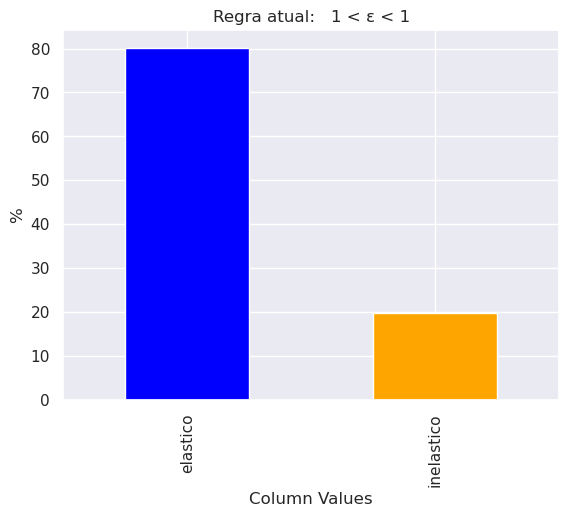

In [23]:
# Count occurrences of each value in the column
value_counts = df_elasticity['elasticidade_item_regra'].value_counts()
percentage_values = value_counts / value_counts.sum() * 100
# Plot the bar chart
percentage_values.plot(kind='bar', color=['blue', 'orange'])
plt.title('Regra atual:   1 < ε < 1')
plt.xlabel('Column Values')
plt.ylabel('%')
plt.show()

## Relaxar regra de elasticidfade

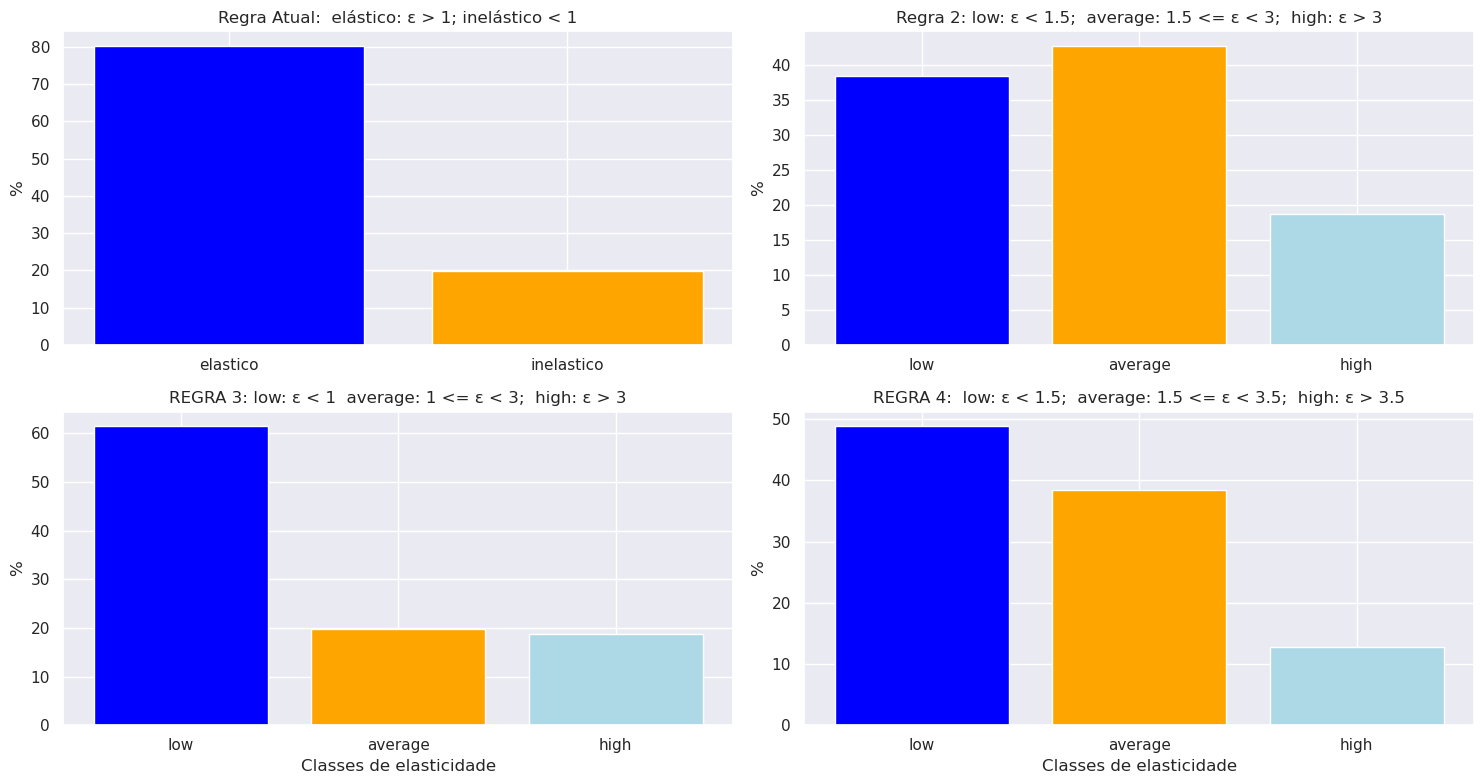

In [27]:
# Assuming you have a DataFrame named df
df_elasticity = results_2[['codigo_item','categoria', 'elast_ORIGINAL', 'r2_ORIGINAL',  'elasticity_category', 'r2_category','utilizado_elasticidade_categoria','elasticity_price', 'r2_score', 'razao_quant_dexconto']]

####### APPLY CONDITIONS ############################
### ITENS
df_elasticity['elasticidade_abs'] = np.abs(df_elasticity['elasticity_price'])

# # Define elasticity conditions 
conditions_elasticity = [
    (df_elasticity['elasticidade_abs'] >= 1),
    (df_elasticity['elasticidade_abs'] < 1)
]

values = ['elastico', 'inelastico']

# Create a new column based on conditions
df_elasticity['elasticidade_item_regra'] = np.select(conditions_elasticity, values)
df_elasticity = df_elasticity[df_elasticity['elasticidade_item_regra'] != '0']

# Count occurrences of each value in the column
value_counts = df_elasticity['elasticidade_item_regra'].value_counts()
percentage_values = value_counts / value_counts.sum() * 100
# Plot the bar chart

fig, ax = plt.subplots(2, 2, figsize=(15, 8))

ax[0, 0].bar(percentage_values.index, percentage_values, color=['blue', 'orange'])
ax[0, 0].set_title('Regra Atual:  elástico: ε > 1; inelástico < 1')
#ax[0, 0].set_xlabel('Classes de elasticidade')
ax[0, 0].set_ylabel('%')






# Assuming you have a DataFrame named df
df_elast_2 = results_2[['codigo_item','categoria', 'elast_ORIGINAL', 'r2_ORIGINAL',  'elasticity_category', 'r2_category','utilizado_elasticidade_categoria','elasticity_price', 'r2_score', 'razao_quant_dexconto']]

####### APPLY CONDITIONS ############################
### ITENS
df_elast_2['elasticidade_abs'] = np.abs(df_elast_2['elasticity_price'])
# Define elasticity conditions 
conditions_elasticity = [
    (df_elast_2['elasticidade_abs'] <= 1.5),
    ((1.5 <= df_elast_2['elasticidade_abs']) & (df_elast_2['elasticidade_abs'] < 3)),
    (df_elast_2['elasticidade_abs'] >= 3)
]

values = ['low', 'average', 'high']

# Create a new column based on conditions
df_elast_2['elasticidade_item_regra'] = np.select(conditions_elasticity, values)
df_elast_2 = df_elast_2[df_elast_2['elasticidade_item_regra'] != '0']


# Count occurrences of each value in the column
value_counts = df_elast_2['elasticidade_item_regra'].value_counts()
percentage_values = value_counts / value_counts.sum() * 100

# Define the order of bars
order = ['low', 'average', 'high']
ax[0, 1].bar(order, percentage_values[order], color=['blue', 'orange', 'lightblue'])
ax[0, 1].set_title('Regra 2: low: ε < 1.5;  average: 1.5 <= ε < 3;  high: ε > 3')
ax[0, 1].set_ylabel('%')




# Assuming you have a DataFrame named df
df_elast_3 = results_2[['codigo_item','categoria', 'elast_ORIGINAL', 'r2_ORIGINAL',  'elasticity_category', 'r2_category','utilizado_elasticidade_categoria','elasticity_price', 'r2_score', 'razao_quant_dexconto']]

####### APPLY CONDITIONS ############################
### ITENS
df_elast_3['elasticidade_abs'] = np.abs(df_elast_3['elasticity_price'])
# Define elasticity conditions 
conditions_elasticity = [
    (df_elast_3['elasticidade_abs'] <= 1),
    ((1 <= df_elast_3['elasticidade_abs']) & (df_elast_3['elasticidade_abs'] < 3)),
    (df_elast_3['elasticidade_abs'] >= 3)
]

values = ['low', 'average', 'high']

# Create a new column based on conditions
df_elast_3['elasticidade_item_regra'] = np.select(conditions_elasticity, values)
df_elast_3 = df_elast_3[df_elast_3['elasticidade_item_regra'] != '0']


# Count occurrences of each value in the column
value_counts = df_elast_3['elasticidade_item_regra'].value_counts()
percentage_values = value_counts / value_counts.sum() * 100

# Define the order of bars
order = ['low', 'average', 'high']

# Plot the bar chart with ordered bars
ax[1, 0].bar(order, percentage_values, color=['blue', 'orange', 'lightblue'])
ax[1, 0].set_title('REGRA 3: low: ε < 1  average: 1 <= ε < 3;  high: ε > 3')
ax[1, 0].set_xlabel('Classes de elasticidade')
ax[1, 0].set_ylabel('%')

# Assuming you have a DataFrame named df
df_elast_4 = results_2[['codigo_item','categoria', 'elast_ORIGINAL', 'r2_ORIGINAL',  'elasticity_category', 'r2_category','utilizado_elasticidade_categoria','elasticity_price', 'r2_score', 'razao_quant_dexconto']]

####### APPLY CONDITIONS ############################
### ITENS
df_elast_4['elasticidade_abs'] = np.abs(df_elast_4['elasticity_price'])
# Define elasticity conditions 
conditions_elasticity = [
    (df_elast_4['elasticidade_abs'] <= 1.5),
    ((1.5 <= df_elast_4['elasticidade_abs']) & (df_elast_4['elasticidade_abs'] < 3.5)),
    (df_elast_4['elasticidade_abs'] >= 3.5)
]

values = ['low', 'average', 'high']

# Create a new column based on conditions
df_elast_4['elasticidade_item_regra'] = np.select(conditions_elasticity, values)
df_elast_4 = df_elast_4[df_elast_4['elasticidade_item_regra'] != '0']


# Count occurrences of each value in the column
value_counts = df_elast_4['elasticidade_item_regra'].value_counts()
percentage_values = value_counts / value_counts.sum() * 100

# Define the order of bars
order = ['low', 'average', 'high']

# Plot the bar chart with ordered bars
ax[1, 1].bar(order, percentage_values, color=['blue', 'orange', 'lightblue'])
ax[1, 1].set_title('REGRA 4:  low: ε < 1.5;  average: 1.5 <= ε < 3.5;  high: ε > 3.5')
ax[1, 1].set_xlabel('Classes de elasticidade')
ax[1, 1].set_ylabel('%')


plt.tight_layout()
plt.show()

## Regra definida com pricing 

In [91]:
### Export data to pricing

# Assuming you have a DataFrame named df
df_elast_2 = results_2[['codigo_item','categoria', 'elast_ORIGINAL', 'r2_ORIGINAL',  'elasticity_category', 'r2_category','utilizado_elasticidade_categoria','elasticity_price', 'r2_score', 'razao_quant_dexconto', 'rent_pct']]

####### APPLY CONDITIONS ############################
### ITENS
df_elast_2['elasticidade_abs'] = np.abs(df_elast_2['elasticity_price'])
# Define elasticity conditions 
conditions_elasticity = [
    (df_elast_2['elasticidade_abs'] <= 1.4),
    ((1.4 < df_elast_2['elasticidade_abs']) & (df_elast_2['elasticidade_abs'] < 2.8)),
    (df_elast_2['elasticidade_abs'] >= 2.8)
]

values = ['low', 'average', 'high']

# Create a new column based on conditions
df_elast_2['elasticidade_item_regra'] = np.select(conditions_elasticity, values)
df_elast_2 = df_elast_2[df_elast_2['elasticidade_item_regra'] != '0']

# # # Extract seleected features
df_elast_2 = df_elast_2[['codigo_item','categoria', 'elast_ORIGINAL', 'r2_ORIGINAL', 'elasticity_category', 'r2_category', 'utilizado_elasticidade_categoria','elasticity_price','elasticidade_item_regra', 
                        'razao_quant_dexconto', 'rent_pct']]

df_elast_2

,codigo_item,categoria,elast_ORIGINAL,r2_ORIGINAL,elasticity_category,r2_category,utilizado_elasticidade_categoria,elasticity_price,elasticidade_item_regra,razao_quant_dexconto,rent_pct
0,27,VITAMINAS AZ,1.91,0.01,-1.49,0.21,1,-1.49,average,10.35,41.87
1,390,PUERICULTURA,0.19,0.01,-0.64,0.01,1,-0.64,low,46.00,54.64
2,655,C5 - BARBITURICO,-0.28,0.02,-0.32,0.16,1,-0.32,low,99.62,43.72
3,1220,LENCO INTIMO,-1.29,0.05,-1.54,0.22,0,-1.29,low,23.66,65.71
4,2170,C1 - BARBITURICO,-0.29,0.01,-1.68,0.32,1,-1.68,average,97.22,18.65
...,...,...,...,...,...,...,...,...,...,...,...
11770,998830,ESMALTAÇÃO,-0.11,0.00,-0.95,0.10,1,-0.95,low,14.12,67.19
11771,998870,ESMALTAÇÃO,-1.35,0.01,-0.95,0.10,1,-0.95,low,12.76,67.32
11772,998890,ESMALTAÇÃO,-2.37,0.02,-0.95,0.10,1,-0.95,low,13.07,66.89
11773,998900,ESMALTAÇÃO,-2.26,0.02,-0.95,0.10,1,-0.95,low,13.62,67.11


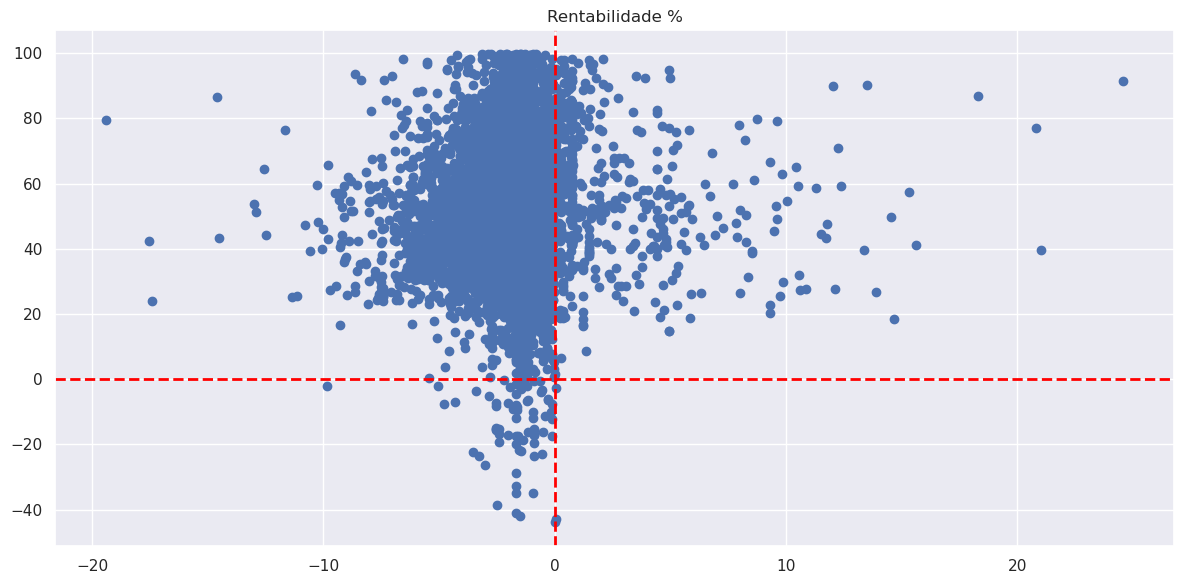

In [112]:
# Scatter plot 1

plt.figure(figsize=(12, 6))  # Adjust the values (width, height) as needed


plt.scatter(df_plot['elasticity_price'], df_plot['rent_pct'])
# Add a horizontal line at y = 0
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Rentabilidade %')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

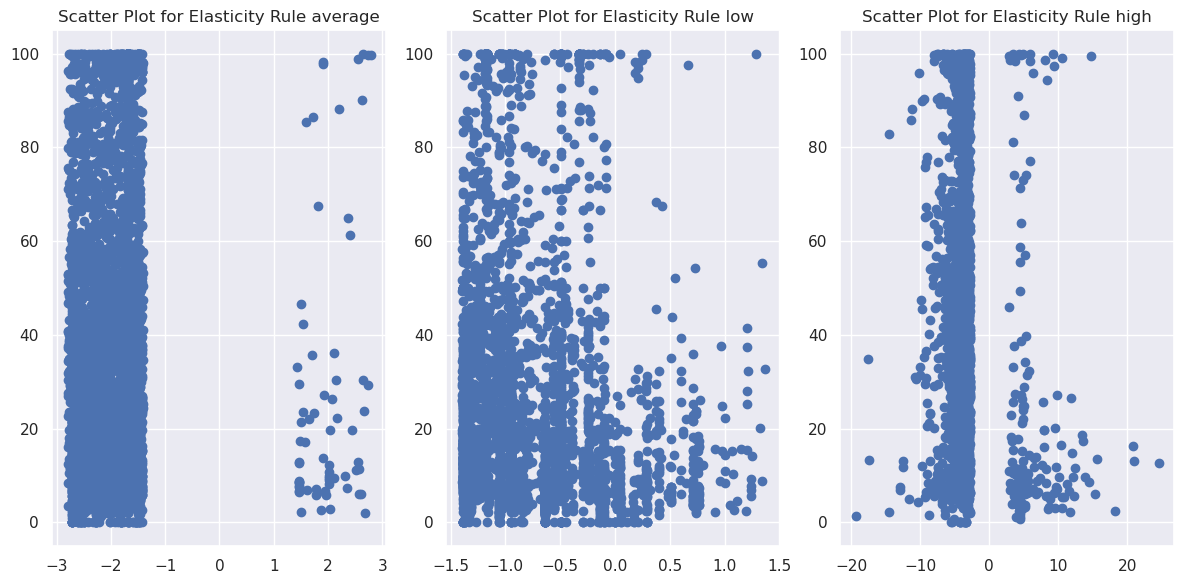

In [101]:

# Set the figure size
plt.figure(figsize=(12, 6))

# Get unique values of 'elasticity_rule'
elasticity_rules = df_plot['elasticidade_item_regra'].unique()

# Iterate over each unique 'elasticity_rule' and create scatter plots
for i, rule in enumerate(elasticity_rules, 1):
    plt.subplot(1, len(elasticity_rules), i)
    
    # Filter data for the current 'elasticity_rule'
    subset_df = df_plot[df_plot['elasticidade_item_regra'] == rule]
    
    # Create scatter plot
    plt.scatter(subset_df['elasticity_price'], subset_df['razao_quant_dexconto'])
    plt.title(f'Scatter Plot for Elasticity Rule {rule}')
    
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
### Save as a excel file

df_elasticity.to_csv('elasticidade_itens.csv', index=False)

### Fazer ghráficos de barras comparando quantidade d itens por elastico e nao elastico